<a href="https://colab.research.google.com/github/crisjosil/MT-PolSAR-Change-Detection-For-Crop-Monitoring-And-Classification/blob/master/AgriSAR_train_NNs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 

# Preliminars: Imports, load datasets

In [ ]:
!pip install fiona
from google.colab import drive
drive.mount('/content/drive')

     |████████████████████████████████| 14.8MB 204kB/s 
Mounted at /content/drive


In [ ]:
# python
import numpy as np
import pandas as pd
import time
import matplotlib.pyplot as plt 
from collections import Counter
import fiona
import os
from itertools import product
from __future__ import print_function
from functools import partial
import pandas as pd
import itertools
from google.colab import files
from pickle import dump
#sklearn
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import balanced_accuracy_score
from imblearn.metrics import geometric_mean_score
from sklearn.metrics import plot_confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler    
from sklearn.preprocessing import Normalizer 
from sklearn.metrics import classification_report
from sklearn.model_selection import GridSearchCV
from sklearn.utils import class_weight

# imblearn
from imblearn.ensemble import BalancedRandomForestClassifier
from imblearn.metrics import classification_report_imbalanced

# Keras
import keras
from keras.models import Sequential
from keras.layers import Dense,Activation,Dropout
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint
from keras.models import load_model
from keras.wrappers.scikit_learn import KerasClassifier
from keras.utils import np_utils
import keras.backend as K
# Tensor flow
import tensorflow as tf
import tensorflow_addons as tfa
print(tf.__version__)
tf.test.gpu_device_name()

/usr/local/lib/python3.6/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.metrics.classification module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be import

2.4.1


'/device:GPU:0'

In [ ]:
N_images=7
N_features=16

### Read PolSAR datasets

In [ ]:
# Name to save the model
model_name_list=['PolSAR_red_V10_Nadam']

In [ ]:
print("Reading PolSAR features test datasets ...")
root="/content/drive/My Drive/Datasets/AgriSAR_Paper2/Final_datasets/PolSAR_F/V10/"
layer_name = "y_train.npy"
y_train0=np.load(root + layer_name,  allow_pickle=True)
layer_name = "y_val.npy"
y_train0_lev2=np.load(root + layer_name,  allow_pickle=True)
layer_name = "y_test.npy"
y_test0=np.load(root + layer_name,  allow_pickle=True)
print(Counter(y_train0))

layer_name = "X_train.npy"
X_train0=np.load(root + layer_name,  allow_pickle=True)
print("Done")
layer_name = "X_val.npy"
X_train0_lev2=np.load(root + layer_name,  allow_pickle=True)
print("Reading testing labels ...")
layer_name = "X_test.npy"
X_test0=np.load(root + layer_name,  allow_pickle=True)
print("Done")

Reading PolSAR features test datasets ...
Counter({9.0: 347355, 2.0: 260715, 4.0: 155104, 7.0: 94766, 5.0: 67502, 0.0: 66061, 3.0: 63305, 6.0: 57005, 1.0: 34693, 8.0: 31703})
Done
Reading testing labels ...
Done


In [ ]:
print("Scaling ...")     
sc = MinMaxScaler()   
X_train = sc.fit_transform(X_train0)
X_train_lev2 = sc.transform(X_train0_lev2)
X_test = sc.transform(X_test0)

print("Reshaping as 2d images ...")
X_train_2d=X_train.reshape(X_train.shape[0],N_images,N_features,1)
X_train_lev2_2d=X_train_lev2.reshape(X_train_lev2.shape[0],N_images,N_features,1)
X_test_2d=X_test.reshape(X_test.shape[0],N_images,N_features,1)
print("Training array shape: "+str(X_train_2d.shape))
print("Validation array shape: "+str(X_train_lev2_2d.shape))
print("Test array shape: "+str(X_test_2d.shape))

Scaling ...
Reshaping as 2d images ...
Training array shape: (1178209, 7, 16, 1)
Validation array shape: (280545, 7, 16, 1)
Test array shape: (326978, 7, 16, 1)


#### Show few random examples of PolSAR features organised as 2d images: 
Every 2d array is a pixel.
Each columns is a PolSAR feature and every row is a date

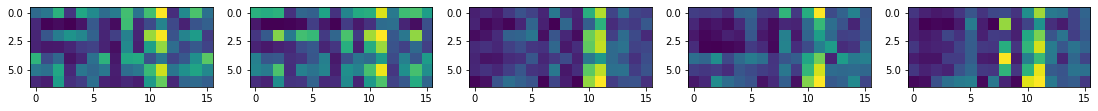

In [ ]:
fig,(ax,ax1,ax2,ax3,ax4)=plt.subplots(nrows=1,ncols=5,figsize=(19,8))
ax.imshow(X_train_2d[0,:,:,0])
ax1.imshow(X_train_2d[100000,:,:,0])
ax2.imshow(X_train_2d[200000,:,:,0])
ax3.imshow(X_train_2d[300000,:,:,0])
ax4.imshow(X_train_2d[400000,:,:,0])

In [ ]:
# name to save model
#model_name_list=['PolSAR_V8_Nadam']

### Read change matrices

In [ ]:
model_name_list=['CM_diag_V7_Nadam']

In [ ]:
# # Change matrices
root="/content/drive/My Drive/Datasets/AgriSAR_Paper2/Final_datasets/CM/V7/"
#var='_.npy'
var='_with_diag.npy'#
layer_name = "y_train"+var
y_train_CM0=np.load(root + layer_name,  allow_pickle=True)
layer_name = "y_test"+var
y_test_CM0=np.load(root + layer_name,  allow_pickle=True)
# layer_name = "y_val"+var
# y_train_CM0_lev2=np.load(root + layer_name,  allow_pickle=True)

print("Reading training data ...")
layer_name = "X_train"+var
X_train_CM0=np.load(root + layer_name,  allow_pickle=True)
X_train_CM0 = np.nan_to_num(X_train_CM0)
print("Reading testing data ...")
layer_name = "X_test"+var
X_test_CM0=np.load(root + layer_name,  allow_pickle=True)
X_test_CM0 = np.nan_to_num(X_test_CM0)
#print("Reading validation data ...")
# layer_name = "X_val"+var
# X_train_CM0_lev2=np.load(root + layer_name,  allow_pickle=True)
# X_train_CM0_lev2 = np.nan_to_num(X_train_CM0_lev2)
print("Done")

Reading training data ...
Reading testing data ...
Done


#### Plot some change matrices without scaling

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Reshaping as 2d images ...
Training array shape: (1176829, 7, 7, 3)
Test array shape: (317634, 7, 7, 3)


Text(0.5, 1.0, 'Crop type: 9.0')

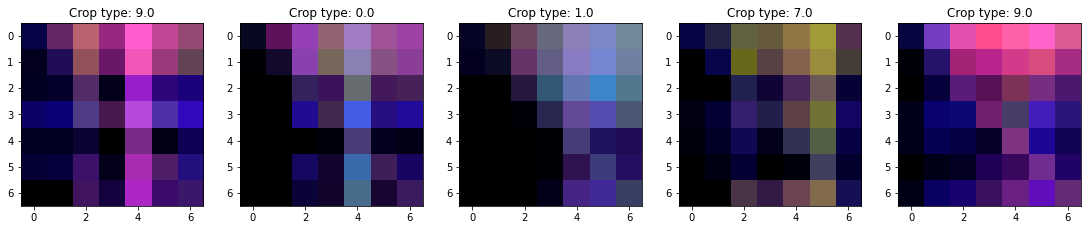

In [ ]:
print("Reshaping as 2d images ...")
X_train_CM0_2d=X_train_CM0.reshape(X_train_CM0.shape[0],N_images,N_images,3)
#X_train_CM0_lev2_2d=X_train_CM0_lev2.reshape(X_train_CM0_lev2.shape[0],N_images,N_images,3)
X_test_CM0_2d=X_test_CM0.reshape(X_test_CM0.shape[0],N_images,N_images,3)
print("Training array shape: "+str(X_train_CM0_2d.shape))
#print("Validation array shape: "+str(X_train_CM_lev2_2d.shape))
print("Test array shape: "+str(X_test_CM0_2d.shape))
#X_train_Tr5 = tf.keras.utils.normalize(X_train_Tr5, axis=1)
#X_test_Ts5 = tf.keras.utils.normalize(X_test_Ts5, axis=1)

fig,(ax,ax1,ax2,ax3,ax4)=plt.subplots(nrows=1,ncols=5,figsize=(19,8))
ax.imshow(X_train_CM0_2d[50000,:,:,:]*5)
ax.set_title("Crop type: "+str(y_train_CM0[50000]))
ax1.imshow(X_train_CM0_2d[100000,:,:,:]*5)
ax1.set_title("Crop type: "+str(y_train_CM0[100000]))
ax2.imshow(X_train_CM0_2d[250000,:,:,:]*5)
ax2.set_title("Crop type: "+str(y_train_CM0[250000]))
ax3.imshow(X_train_CM0_2d[370000,:,:,:]*5)
ax3.set_title("Crop type: "+str(y_train_CM0[370000]))
ax4.imshow(X_train_CM0_2d[800000,:,:,:]*5)
ax4.set_title("Crop type: "+str(y_train_CM0[800000]))

#### Scale and plot some change matrices with scaling
Note: Because of the min_max scaling, the change matrix no longer shows physical scattering mechanisms

In [ ]:
print("Scaling ...")     
# without normalizing change matrix   
# X_train_CM = X_train_CM0
# X_train_CM_lev2 = X_train_CM0_lev2
# X_test_CM = X_test_CM0

sc = MinMaxScaler()
#sc = StandardScaler() 
#sc = Normalizer() 
X_train_CM = sc.fit_transform(X_train_CM0)
#X_train_CM_lev2 = sc.transform(X_train_CM0_lev2) 
X_test_CM = sc.transform(X_test_CM0)
# save the scaler
dump(sc, open('scaler.pkl', 'wb'))

print("Reshaping as 2d images ...")
X_train_CM_2d=X_train_CM.reshape(X_train_CM.shape[0],N_images,N_images,3)
#X_train_CM_lev2_2d=X_train_CM_lev2.reshape(X_train_CM_lev2.shape[0],N_images,N_images,3)
X_test_CM_2d=X_test_CM.reshape(X_test_CM.shape[0],N_images,N_images,3)
print("Training array shape: "+str(X_train_CM_2d.shape))
#print("Validation array shape: "+str(X_train_CM_lev2_2d.shape))
print("Test array shape: "+str(X_test_CM_2d.shape))
#X_train_Tr5 = tf.keras.utils.normalize(X_train_Tr5, axis=1)
#X_test_Ts5 = tf.keras.utils.normalize(X_test_Ts5, axis=1)

Scaling ...
Reshaping as 2d images ...
Training array shape: (1176829, 7, 7, 3)
Test array shape: (317634, 7, 7, 3)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


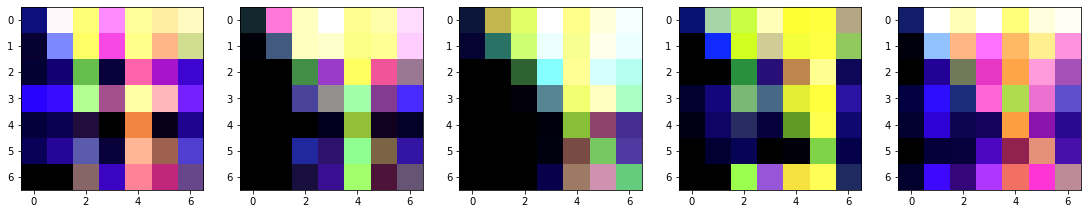

In [ ]:
fig,(ax,ax1,ax2,ax3,ax4)=plt.subplots(nrows=1,ncols=5,figsize=(19,8))
ax.imshow(X_train_CM_2d[50000,:,:,:]*5)
#ax.set_title("Crop type: "+str(y_train0[646782]))
ax1.imshow(X_train_CM_2d[100000,:,:,:]*5)
#ax1.set_title("Crop type: "+str(y_train0[100000]))
ax2.imshow(X_train_CM_2d[250000,:,:,:]*5)
#ax2.set_title("Crop type: "+str(y_train0[250000]))
ax3.imshow(X_train_CM_2d[370000,:,:,:]*5)
#ax3.set_title("Crop type: "+str(y_train0[370000]))
ax4.imshow(X_train_CM_2d[800000,:,:,:]*5)
#ax4.set_title("Crop type: "+str(y_train0[800000]))

In [ ]:
# fig,(ax,ax1,ax2,ax3,ax4)=plt.subplots(nrows=1,ncols=5,figsize=(19,8))
# ax.imshow(X_train_CM_lev2_2d[0,:,:,:]*5)
# ax.set_title("Crop type: "+str(y_train_CM0[0]))
# ax1.imshow(X_train_CM_lev2_2d[100000,:,:,:]*5)
# ax1.set_title("Crop type: "+str(y_train_CM0[10000]))
# ax2.imshow(X_train_CM_lev2_2d[25000,:,:,:]*5)
# ax2.set_title("Crop type: "+str(y_train_CM0[25000]))
# ax3.imshow(X_train_CM_lev2_2d[37000,:,:,:]*5)
# ax3.set_title("Crop type: "+str(y_train_CM0[37000]))
# ax4.imshow(X_train_CM_lev2_2d[-1,:,:,:]*5)
# ax4.set_title("Crop type: "+str(y_train_CM0[-1]))

# Custom Loss function for imbalanced classification


*   Uses weighted categorical cross entropy




### Class and sample_weights

Note that here we give more weights to the classes and samples with lower number of samples represented in the training data

In [ ]:
#y_tr = y_train_CM0 # Enable for CM
y_tr = y_train0 # enable for PolSAR

In [ ]:
# Determine weight of each class according to number of samples
# For train
class_weights = class_weight.compute_class_weight('balanced',
                                                 np.unique(y_tr),
                                                 y_tr)
class_weight_dict = dict(enumerate(class_weights/class_weights.max())) # normalize the weights to one

sample_weight=np.zeros(y_tr.shape)
for r in np.unique(y_tr):
  sample_weight=np.where(y_tr==r,class_weight_dict[r],sample_weight)

print(np.unique(sample_weight))
print(class_weight_dict)

[0.09126974 0.12160021 0.20439834 0.33453981 0.46966016 0.47990494
 0.50079773 0.5561442  0.91381547 1.        ]
{0: 0.4799049363467099, 1: 0.9138154670971089, 2: 0.12160021479393208, 3: 0.5007977252981597, 4: 0.20439833917887354, 5: 0.4696601582175343, 6: 0.5561441978773792, 7: 0.3345398138572906, 8: 1.0, 9: 0.09126973845201596}


In [ ]:
# Custom loss function with costs
def w_categorical_crossentropy(y_true, y_pred, weights):
    nb_cl = len(weights)
    final_mask = K.zeros_like(y_pred[:, 0])
    y_pred_max = K.max(y_pred, axis=1)
    y_pred_max = K.expand_dims(y_pred_max, 1)
    y_pred_max_mat = K.equal(y_pred, y_pred_max)
    for c_p, c_t in product(range(nb_cl), range(nb_cl)):

        final_mask += (K.cast(weights[c_t, c_p],K.floatx()) * K.cast(y_pred_max_mat[:, c_p] ,K.floatx())* K.cast(y_true[:, c_t],K.floatx()))
    return K.categorical_crossentropy(y_pred, y_true) * final_mask

In [ ]:
# Array with weights
w_array = np.ones((10,10))
for i in range(10):
  w_array[:,i]=class_weight_dict[i]
for i in range(10):
  w_array[i,i]=1
w_array

array([[1.        , 0.91381547, 0.12160021, 0.50079773, 0.20439834,
        0.46966016, 0.5561442 , 0.33453981, 1.        , 0.09126974],
       [0.47990494, 1.        , 0.12160021, 0.50079773, 0.20439834,
        0.46966016, 0.5561442 , 0.33453981, 1.        , 0.09126974],
       [0.47990494, 0.91381547, 1.        , 0.50079773, 0.20439834,
        0.46966016, 0.5561442 , 0.33453981, 1.        , 0.09126974],
       [0.47990494, 0.91381547, 0.12160021, 1.        , 0.20439834,
        0.46966016, 0.5561442 , 0.33453981, 1.        , 0.09126974],
       [0.47990494, 0.91381547, 0.12160021, 0.50079773, 1.        ,
        0.46966016, 0.5561442 , 0.33453981, 1.        , 0.09126974],
       [0.47990494, 0.91381547, 0.12160021, 0.50079773, 0.20439834,
        1.        , 0.5561442 , 0.33453981, 1.        , 0.09126974],
       [0.47990494, 0.91381547, 0.12160021, 0.50079773, 0.20439834,
        0.46966016, 1.        , 0.33453981, 1.        , 0.09126974],
       [0.47990494, 0.91381547, 0.1216002

In [ ]:
ncce = partial(w_categorical_crossentropy, weights=w_array)
ncce.__name__ ='w_categorical_crossentropy'

# Custom metrics and callbacks

*   f1_macro
*   Balanced accuracy
*   Normal accuracy, just for information


*   Callback to save the model which achieves best balanced accuracy
*   Callback to adjust learning rate: case-specific  







In [ ]:
import sklearn.metrics as sklm
class My_Metrics(tf.keras.callbacks.Callback):
    def __init__(self, X_validation, y_validation, save_model_name, logs={}):
        #self.confusion = []
        #self.precision = []
        #self.recall = []
        self.f1s = [0]
        #self.kappa = []
        #self.auc = []
        self.bal_acc=[0]
        self.Imbal_acc=[0]
        # Counter thay increases by one if balanced accuracy does not improve. 
        # Training stops when the counter equals the patience 
        self.improving = 0
        self.my_patience= 3
        self.X_validation = X_validation
        self.y_validation = y_validation
        self.save_model_name=save_model_name
         

    def on_epoch_end(self, epoch, lr, logs={}):
        y_pred = np.argmax( self.model.predict(self.X_validation), axis=-1)      
        #self.confusion.append(confusion_matrix(y_test, y_pred))
        #self.kappa.append(cohen_kappa_score(y_test, y_pred))
        f1_macro = f1_score(self.y_validation, y_pred, average='macro')
        Bal_acc = balanced_accuracy_score(self.y_validation, y_pred, sample_weight=None, adjusted=False)
        Imb_acc = accuracy_score(self.y_validation, y_pred, sample_weight=None)
        self.bal_acc.append(Bal_acc)
        self.f1s.append(f1_macro)
        print(" ")
        print("Bal_accuracy: "+str(round(Bal_acc,3)))
        print("F1_macro: "+str(round(f1_macro,3)))
        print("Imbal_accuracy: "+str(round(Imb_acc,3)))
        
        if all(i < Bal_acc for i in self.Imbal_acc) == True:  # replaces callback to save model
          print("Highest balanced accuracy so far. Saving model ...")
          self.improving = 0
          self.model.save(self.save_model_name+'.h5')
        else:
          self.improving = self.improving + 1
          print("Balanced accuracy did not improve. ("+str(self.improving)+")")

        if self.improving == self.my_patience:
          self.model.stop_training = True
          print("Balanced accuracy did not improve in "+str(self.my_patience)+" epochs. Stopping training.")
        # else:
        #   print("Balanced accuracy improved wrt the last 3 epochs")
        
        self.Imbal_acc.append(Bal_acc)
        
# This function keeps the initial learning rate for the first 4 epochs  
# and decreases it exponentially after that.  
def scheduler(epoch, lr):
    if epoch < 2:
      return lr
    else:
      #return lr * tf.math.exp(-0.1)
      lr = 0.00001
      return lr
    #return

# Define a DNN model with the functional Keras API

In [ ]:
def model_3_512(in_tensor, Num_classes, name_in_lay):
  # functional API model
  # define two sets of inputs
  input_1 = tf.keras.Input(shape=(in_tensor.shape[1],in_tensor.shape[2],in_tensor.shape[3]),name=name_in_lay)
  #input_2 = tf.keras.Input(shape=(X_train_CM_2d.shape[1],X_train_CM_2d.shape[2],X_train_CM_2d.shape[3]))
  x1 = tf.keras.layers.Flatten(name='Flatten')(input_1)
  #x = tf.keras.layers.concatenate([x1,x2])
  x = tf.keras.layers.BatchNormalization(name='BN_1')(x1)
  x = tf.keras.layers.Dense(512,activation='relu',kernel_initializer='he_normal',name='Dense_1')(x)
  x = tf.keras.layers.BatchNormalization(name='BN_2')(x)
  #x = tf.keras.layers.Dropout(0.2)(x)
  x = tf.keras.layers.Dense(512,activation='relu',kernel_initializer='he_normal',name='Dense_2')(x)
  x = tf.keras.layers.BatchNormalization(name='BN_3')(x)
  #x = tf.keras.layers.Dropout(0.2)(x)
  x = tf.keras.layers.Dense(512,activation='relu',kernel_initializer='he_normal',name='Dense_3')(x)
  x = tf.keras.layers.BatchNormalization(name='BN_4')(x)
  #x = tf.keras.layers.Dropout(0.2)(x)
  outputs = tf.keras.layers.Dense(Num_classes, activation='softmax')(x)
  model = tf.keras.Model(inputs=input_1, outputs=outputs)
  #model = tf.keras.Model(inputs=[input_1,input_2], outputs=outputs)
  return(model)

# Define input datasets for train\validation\test

#### Enable for PolSAR

In [ ]:
#convert class vectors to binary class matrices (as required by the categorical cross entropy loss)
from keras.utils import np_utils
print(y_train0[0])
Y_train = np_utils.to_categorical(y_train0, np.unique(y_train0).shape[0])
Y_val = np_utils.to_categorical(y_train0_lev2, np.unique(y_train0_lev2).shape[0])
Y_test = np_utils.to_categorical(y_test0, np.unique(y_test0).shape[0])
print(Y_train[0])

y_for_training=Y_train
y_for_validating=Y_val
y_for_testing=Y_test
y_for_validating_sparse=y_train0_lev2
y_for_testing_sparse=y_test0

2.0
[0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]


In [ ]:
# Enable for PolSAR input data
X_for_training=X_train_2d
X_for_testing=X_test_2d
X_for_validating=X_train_lev2_2d
name_in_lay='PolSAR_Input'
#model_name_list=['PolSAR_Adam_1e_4','PolSAR_SGD_1e_4','PolSAR_Nadam_1e_4']


#### Enable for Change matrix

In [ ]:
#Enable for change matrix input data
X_for_training=X_train_CM_2d
X_for_testing= X_test_CM_2d
X_for_validating=X_train_CM_lev2_2d
# save_model_name = 'CM_adam_1e_3.h5'
name_in_lay='CM_Input'
#model_name_list=['CM_alb_Adam','CM_alb_SGD','CM_alb_Nadam']


In [ ]:
np.unique(y_train_CM0)

array([0., 1., 2., 3., 4., 5., 6., 7., 8., 9.])

In [ ]:
np.unique(y_train_CM0_lev2)

array([0., 1., 2., 3., 4., 5., 6., 7., 8., 9.])

In [ ]:
np.unique(y_test_CM0)

array([0., 1., 2., 3., 4., 5., 6., 7., 8., 9.])

In [ ]:
# convert class vectors to binary class matrices (as required by the categorical cross entropy loss)
from keras.utils import np_utils
print(y_train_CM0[50000])
Y_train = np_utils.to_categorical(y_train_CM0, np.unique(y_train_CM0).shape[0])
Y_val = np_utils.to_categorical(y_train_CM0_lev2, np.unique(y_train_CM0_lev2).shape[0])
Y_test = np_utils.to_categorical(y_test_CM0, np.unique(y_test_CM0).shape[0])
print(Y_train[50000])

y_for_training=Y_train
y_for_validating=Y_val
y_for_testing=Y_test
y_for_validating_sparse=y_train_CM0_lev2
y_for_testing_sparse=y_test_CM0

9.0
[0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]


In [ ]:
#print(X_train_2d.shape)
#print(X_train_CM_2d.shape)

#### Function to evaluate performance

In [ ]:
def plot_my_confusion_matrix(cm, classes,
                        title='Confusion matrix',
                        cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    """
    fig,ax=plt.subplots(1,figsize=(12,8))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
            horizontalalignment="center",
            color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

def eval_model(y_test0,y_pred,classes,model_name):
  df_metrics_w=pd.DataFrame(index=['f1_macro','G_mean_macro','Balanced accuracy','Imbalanced accuracy'])
  f1_macro = f1_score(y_test0, y_pred, average='macro')
  G_mean_macro = geometric_mean_score(y_test0, y_pred, average='macro', sample_weight=None)
  Bal_acc = balanced_accuracy_score(y_test0, y_pred, sample_weight=None, adjusted=False)
  Imbal_acc = accuracy_score(y_test0, y_pred)

  list_of_metrics=[f1_macro,G_mean_macro,Bal_acc,Imbal_acc]
  df_metrics_w["NN_All_small"] = list_of_metrics   
  cm = confusion_matrix(y_test0, y_pred,normalize='true')
  cm = np.round(cm, 2)
  plot_my_confusion_matrix(cm, classes,cmap=plt.cm.Blues)
  #print('Balanced Accuracy: %.3f' % Bal_acc)
  #print('f1_macro: %.3f' % f1_macro)
  print(df_metrics_w)
  print(" ")
  report = sklm.classification_report(y_test0,y_pred,target_names=classes,output_dict=True)
  df_report = pd.DataFrame(report).transpose()
  print(df_report)
  print(" ")
  df_metrics_w.to_csv(model_name+'_metrics.csv')
  files.download(model_name+'_metrics.csv')
  df_report.to_csv(model_name+'_report.csv')
  files.download(model_name+'_report.csv')

  files.download(model_name+'.h5') #"birds.h5"

# Compile, fit and test the model for the 10 classes
Defining datasets: Since labels are the same for PolSAR or for Change matrix, we can use the same arrays in both cases

In [ ]:
#optimizer1 = tf.keras.optimizers.Adam(lr=1e-3) # try also 3e-6
optimizer2 = tf.keras.optimizers.Adam(lr=1e-4) # try also 3e-6
#optimizer3 = tf.keras.optimizers.SGD(lr=1e-3) # try also 3e-6
optimizer4 = tf.keras.optimizers.SGD(lr=1e-4) # try also 3e-6
optimizer5 = tf.keras.optimizers.Nadam(lr=5e-4) # try also 3e-6
#optimizers_list=[optimizer1,optimizer2,optimizer3,optimizer4]
#model_name_list=['CM_Adam_1e_3','CM_Adam_1e_4','CM_SGD_1e_3','CM_SGD_1e_4']

optimizers_list=[optimizer5]


In [ ]:
Lr_call = tf.keras.callbacks.LearningRateScheduler(scheduler)

In [ ]:
classes = ['Barley', 'Canaryseed', 'Canola', 'Durum Wheat', 'Field Pea', 'Flax', 'Lentil', 'Mixed Pasture', 'Oat', 'Spring Wheat']

for i in range(len(optimizers_list)):
  save_model_name= model_name_list[i]
  metrics_mine=My_Metrics(X_for_validating,y_for_validating_sparse,save_model_name=save_model_name)  # Pass sparse ground truth, not categorical
  model=model_3_512(in_tensor = X_for_training, Num_classes = 10, name_in_lay = name_in_lay) # in_tensor just to geht the input shape
  dot_img_file = '/content/model_1.png'

  optimizer = optimizers_list[i]
  model.compile(optimizer = optimizer,
                loss = ncce,
                #tf.keras.losses.SparseCategoricalCrossentropy(),#'categorical_crossentropy' is for one hot encoded labels, # , #adam: adaptive moment estimation
                metrics=['accuracy'])

  metrics_mine.on_train_begin()
  history = model.fit(x=X_for_training, y=y_for_training, 
                      epochs = 20, batch_size = 32,
                      validation_data=(X_for_validating,y_for_validating),
                      verbose=True, 
                      #callbacks=[metrics_mine],
                      callbacks=[metrics_mine],#,Lr_call],
                      #class_weight=class_weight_dict,
                      sample_weight = sample_weight #sample_weight#sample_weight_small#sample_weight_val 
  )
  model_CS = load_model(save_model_name+'.h5', custom_objects={'w_categorical_crossentropy': ncce})
  y_pred = np.argmax(model_CS.predict(X_for_validating), axis=-1)
  eval_model(y_for_validating_sparse,y_pred,classes,save_model_name)  


In [ ]:
# model_test = load_model(save_model_name+'.h5', custom_objects={'w_categorical_crossentropy': ncce})
# y_pred1 = np.argmax(model_test.predict(X_for_testing), axis=-1)
# eval_model(y_for_testing_sparse,y_pred1,classes,save_model_name)  

# Compile, fit and test the model for the 6 classes (combining cereals)

In [ ]:
# y_train0 = y_train_CM0 # enable for CM
# y_test0 = y_test_CM0
# y_val0 = y_train_CM0_lev2

In [ ]:
y_train_red=y_train0.copy() 
y_train_red=np.where(y_train0==0,0,y_train_red) # Barley
y_train_red=np.where(y_train0==1,0,y_train_red) # Canaray seed
y_train_red=np.where(y_train0==2,1,y_train_red) # Canola
y_train_red=np.where(y_train0==3,0,y_train_red) # Durum wheat
y_train_red=np.where(y_train0==4,2,y_train_red) # field Peas 
y_train_red=np.where(y_train0==5,3,y_train_red) # Flax
y_train_red=np.where(y_train0==6,4,y_train_red) # Lentil
y_train_red=np.where(y_train0==7,5,y_train_red) # Mixed Pasture
y_train_red=np.where(y_train0==8,0,y_train_red) # Oat
y_train_red=np.where(y_train0==9,0,y_train_red) # spring wheat

In [ ]:
y_test_red=y_test0.copy() 
y_test_red=np.where(y_test0==0,0,y_test_red) # Barley
y_test_red=np.where(y_test0==1,0,y_test_red) # Canaray seed
y_test_red=np.where(y_test0==2,1,y_test_red) # Canola
y_test_red=np.where(y_test0==3,0,y_test_red) # Durum wheat
y_test_red=np.where(y_test0==4,2,y_test_red) # field Peas 
y_test_red=np.where(y_test0==5,3,y_test_red) # Flax
y_test_red=np.where(y_test0==6,4,y_test_red) # Lentil
y_test_red=np.where(y_test0==7,5,y_test_red) # Mixed Pasture
y_test_red=np.where(y_test0==8,0,y_test_red) # Oat
y_test_red=np.where(y_test0==9,0,y_test_red) # spring wheat

In [ ]:
y_val0 = y_train0_lev2
y_val_red=y_val0.copy() 
y_val_red=np.where(y_val0==0,0,y_val_red) # Barley
y_val_red=np.where(y_val0==1,0,y_val_red) # Canaray seed
y_val_red=np.where(y_val0==2,1,y_val_red) # Canola
y_val_red=np.where(y_val0==3,0,y_val_red) # Durum wheat
y_val_red=np.where(y_val0==4,2,y_val_red) # field Peas 
y_val_red=np.where(y_val0==5,3,y_val_red) # Flax
y_val_red=np.where(y_val0==6,4,y_val_red) # Lentil
y_val_red=np.where(y_val0==7,5,y_val_red) # Mixed Pasture
y_val_red=np.where(y_val0==8,0,y_val_red) # Oat
y_val_red=np.where(y_val0==9,0,y_val_red) # spring wheat

In [ ]:
# convert class vectors to binary class matrices
print(y_test_red[0])
Y_train_red = np_utils.to_categorical(y_train_red, np.unique(y_train_red).shape[0])
Y_test_red = np_utils.to_categorical(y_test_red, np.unique(y_test_red).shape[0])
Y_val_red = np_utils.to_categorical(y_val_red, np.unique(y_val_red).shape[0])
print(Y_test_red[0])

4.0
[0. 0. 0. 0. 1. 0.]


In [ ]:
print(Counter(y_train_red))

Counter({0.0: 543117, 1.0: 260715, 2.0: 155104, 5.0: 94766, 3.0: 67502, 4.0: 57005})


In [ ]:
class_weights_red = class_weight.compute_class_weight('balanced',
                                                 np.unique(y_train_red),
                                                 y_train_red)
class_weight_dict_red = dict(enumerate(class_weights_red/class_weights_red.max())) 
# for test
# sample_weight_test_red=np.zeros(y_test_red.shape)
# for r in np.unique(y_test_red):
#   sample_weight_test=np.where(y_test_red==r,class_weight_dict_red[r],sample_weight_test_red)

# Create an array as big as the training samples.
# To each sample assign a weight depending on its class weight
sample_weight_red=np.zeros(y_train_red.shape) 
# fill the array with a sample weight equal to the class weight
for r in np.unique(y_train_red):
  sample_weight_red=np.where(y_train_red==r,class_weight_dict_red[r],sample_weight_red) 
print(np.unique(sample_weight_red))
print(sample_weight_red.shape)

[0.10495897 0.21864872 0.36752759 0.60153431 0.8444935  1.        ]
(1178209,)


In [ ]:
w_array_red = np.ones((6,6))
for i in range(6):
  w_array_red[:,i]=class_weight_dict_red[i]
for i in range(6):
  w_array_red[i,i]=1
w_array_red

array([[1.        , 0.21864872, 0.36752759, 0.8444935 , 1.        ,
        0.60153431],
       [0.10495897, 1.        , 0.36752759, 0.8444935 , 1.        ,
        0.60153431],
       [0.10495897, 0.21864872, 1.        , 0.8444935 , 1.        ,
        0.60153431],
       [0.10495897, 0.21864872, 0.36752759, 1.        , 1.        ,
        0.60153431],
       [0.10495897, 0.21864872, 0.36752759, 0.8444935 , 1.        ,
        0.60153431],
       [0.10495897, 0.21864872, 0.36752759, 0.8444935 , 1.        ,
        1.        ]])

In [ ]:
ncce_red = partial(w_categorical_crossentropy, weights=w_array_red)
ncce_red.__name__ ='w_categorical_crossentropy_red'

In [ ]:
# Enable for PolSAR input data
#X_for_training=X_train_2d[:5000]
#X_for_testing=X_test_2d[:5000]
#X_for_validating=

In [ ]:
# Enable for change matrix input data
# X_for_training=X_train_CM_2d
# X_for_testing=X_test_CM_2d
#X_for_validating=

In [ ]:
y_for_training=Y_train_red
y_for_validating=Y_val_red
y_for_testing=Y_test_red
y_for_validating_sparse=y_val_red
y_for_testing_sparse=y_test_red

In [ ]:
#model_name_list_red=['PolSAR_red_Adam1','PolSAR_red_SGD1','PolSAR_red_Nadam1']
model_name_list_red=['PolSAR_red_V10_Nadam']

In [ ]:
model_name_list_red

['PolSAR_red_V10_Nadam']

In [ ]:
classes_red = ['Cereals', 'Canola', 'Field Pea', 'Flax', 'Lentil', 'Mixed Pasture']
for i in range(len(optimizers_list)):
  save_model_name= model_name_list_red[i]
  metrics_mine=My_Metrics(X_for_validating,y_for_validating_sparse,save_model_name=save_model_name)  # Pass sparse ground truth, not categorical
  model_reduced=model_3_512(in_tensor = X_for_training, Num_classes = 6, name_in_lay = name_in_lay)
  dot_img_file = '/content/model_1.png'
  #tf.keras.utils.plot_model(model_reduced, to_file=dot_img_file, show_shapes=True) 
  optimizer = optimizers_list[i]
  model_reduced.compile(optimizer = optimizer,
                loss = ncce_red,
                #tf.keras.losses.SparseCategoricalCrossentropy(),#'categorical_crossentropy' is for one hot encoded labels, # , #adam: adaptive moment estimation
                metrics=['accuracy'])

  metrics_mine.on_train_begin()
  history = model_reduced.fit(x=X_for_training, y=y_for_training, 
                      epochs = 20, batch_size = 32,
                      validation_data=(X_for_validating,y_for_validating),
                      verbose=True, 
                      #callbacks=[metrics_mine],
                      callbacks=[metrics_mine,Lr_call],
                      #class_weight=class_weight_dict,
                      sample_weight = sample_weight_red #sample_weight#sample_weight_small#sample_weight_val 
  )
  model_CS = load_model(save_model_name+'.h5', custom_objects={'w_categorical_crossentropy_red': ncce_red})
  y_pred = np.argmax(model_CS.predict(X_for_validating), axis=-1)
  eval_model(y_for_validating_sparse,y_pred,classes_red,save_model_name)  


# Naive Concatenation of inputs

In [ ]:
def model_conc(in_tensor1, in_tensor2, Num_classes, name_in_lay1, name_in_lay2):
  # functional API model
  # define two sets of inputs
  input_1 = tf.keras.Input(shape= (in_tensor1.shape[1],in_tensor1.shape[2],in_tensor1.shape[3]),  name=name_in_lay1)
  input_2 = tf.keras.Input(shape=(in_tensor2.shape[1],in_tensor2.shape[2],in_tensor2.shape[3]),name=name_in_lay2)

  x1 = tf.keras.layers.Flatten(name='Flatten1')(input_1)
  x2 = tf.keras.layers.Flatten(name='Flatten2')(input_2)

  x = tf.keras.layers.concatenate([x1,x2])

  x = tf.keras.layers.BatchNormalization(name='BN_1')(x)
  x = tf.keras.layers.Dense(512,activation='relu',name='Dense_1')(x)
  x = tf.keras.layers.BatchNormalization(name='BN_2')(x)
  x = tf.keras.layers.Dense(512,activation='relu',name='Dense_2')(x)
  x = tf.keras.layers.BatchNormalization(name='BN_3')(x)
  x = tf.keras.layers.Dense(512,activation='relu',name='Dense_3')(x)
  x = tf.keras.layers.BatchNormalization(name='BN_4')(x)

  outputs = tf.keras.layers.Dense(Num_classes, activation='softmax')(x)
  model = tf.keras.Model(inputs=[input_1,input_2], outputs=outputs)
  #model = tf.keras.Model(inputs=[input_1,input_2], outputs=outputs)
  return(model)

In [ ]:
y_for_training=Y_train
y_for_testing=Y_test
y_for_testing_sparse=y_test0
#y_for_validating=[:5000]

In [ ]:
samples=X_train_2d.shape[0]
samples

947657

In [ ]:
model_name_list=['NConcat_Adam_1e_4','NConcat_SGD_1e_4','NConcat_Nadam_1e_4']

In [ ]:
Lr_call = tf.keras.callbacks.LearningRateScheduler(scheduler)


Epoch 1/30
29613/29615 [============================>.] - ETA: 0s - loss: 0.1463 - accuracy: 0.9112 
Bal_accuracy: 0.695
F1_macro: 0.666
Imbal_accuracy: 0.74
Highest balanced accuracy so far. Saving model ...
29615/29615 [==============================] - 386s 13ms/step - loss: 0.1463 - accuracy: 0.9112 - val_loss: 2.1074 - val_accuracy: 0.7405
Epoch 2/30
29614/29615 [============================>.] - ETA: 0s - loss: 0.0842 - accuracy: 0.9412 
Bal_accuracy: 0.696
F1_macro: 0.683
Imbal_accuracy: 0.762
Highest balanced accuracy so far. Saving model ...
29615/29615 [==============================] - 392s 13ms/step - loss: 0.0842 - accuracy: 0.9412 - val_loss: 1.7733 - val_accuracy: 0.7624
Epoch 3/30
29615/29615 [==============================] - ETA: 0s - loss: 0.0527 - accuracy: 0.9577 
Bal_accuracy: 0.685
F1_macro: 0.68
Imbal_accuracy: 0.769
Balanced accuracy did not improve. (1)
29615/29615 [==============================] - 406s 14ms/step - loss: 0.0527 - accuracy: 0.9577 - val_loss: 

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Epoch 1/30
29613/29615 [============================>.] - ETA: 0s - loss: 0.5709 - accuracy: 0.7438 
Bal_accuracy: 0.7
F1_macro: 0.655
Imbal_accuracy: 0.664
Highest balanced accuracy so far. Saving model ...
29615/29615 [==============================] - 460s 16ms/step - loss: 0.5709 - accuracy: 0.7438 - val_loss: 3.0888 - val_accuracy: 0.6642
Epoch 2/30
29612/29615 [============================>.] - ETA: 0s - loss: 0.2985 - accuracy: 0.8464 
Bal_accuracy: 0.711
F1_macro: 0.667
Imbal_accuracy: 0.682
Highest balanced accuracy so far. Saving model ...
29615/29615 [==============================] - 368s 12ms/step - loss: 0.2985 - accuracy: 0.8464 - val_loss: 2.8530 - val_accuracy: 0.6824
Epoch 3/30
29614/29615 [============================>.] - ETA: 0s - loss: 0.2673 - accuracy: 0.8562 
Bal_accuracy: 0.711
F1_macro: 0.667
Imbal_accuracy: 0.684
Highest balanced accuracy so far. Saving model ...
29615/29615 [==============================] - 353s 12ms/step - loss: 0.2673 - accuracy: 0.8562 

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Epoch 1/30
29614/29615 [============================>.] - ETA: 0s - loss: 0.1464 - accuracy: 0.9114 
Bal_accuracy: 0.703
F1_macro: 0.67
Imbal_accuracy: 0.747
Highest balanced accuracy so far. Saving model ...
29615/29615 [==============================] - 544s 18ms/step - loss: 0.1464 - accuracy: 0.9114 - val_loss: 2.3696 - val_accuracy: 0.7471
Epoch 2/30
29614/29615 [============================>.] - ETA: 0s - loss: 0.0833 - accuracy: 0.9401 
Bal_accuracy: 0.686
F1_macro: 0.664
Imbal_accuracy: 0.759
Balanced accuracy did not improve. (1)
29615/29615 [==============================] - 579s 20ms/step - loss: 0.0833 - accuracy: 0.9401 - val_loss: 2.0499 - val_accuracy: 0.7586
Epoch 3/30
29614/29615 [============================>.] - ETA: 0s - loss: 0.0534 - accuracy: 0.9565 
Bal_accuracy: 0.696
F1_macro: 0.687
Imbal_accuracy: 0.777
Balanced accuracy did not improve. (2)
29615/29615 [==============================] - 566s 19ms/step - loss: 0.0534 - accuracy: 0.9565 - val_loss: 1.6945 - va

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

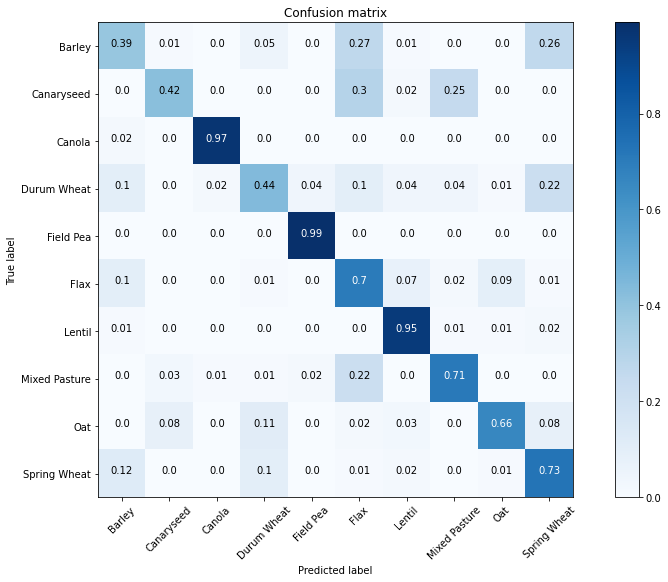

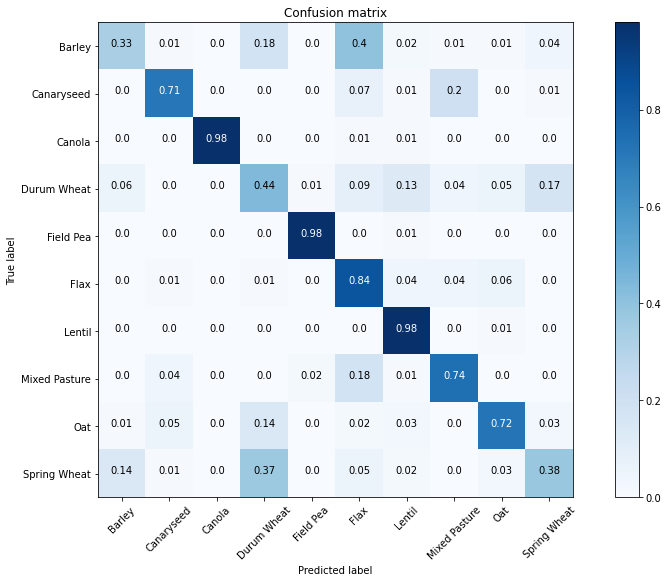

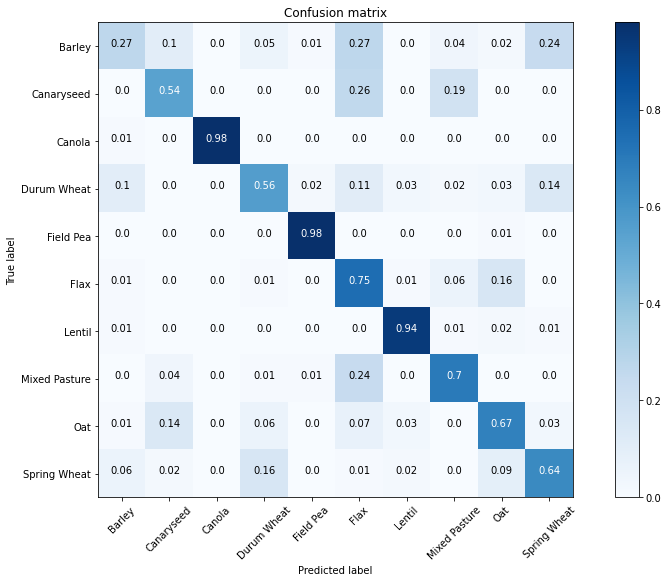

In [ ]:
for i in range(len(model_name_list)):
  save_model_name=model_name_list[i]
  metrics_mine=My_Metrics([X_train_lev2_2d[:samples],X_train_CM_lev2_2d[:samples]],y_for_validating_sparse[:samples],save_model_name)  # Pass sparse ground truth, not categorical
  model=model_conc(in_tensor1 = X_train_2d[:samples],in_tensor2=X_train_CM_2d[:samples], Num_classes = 10, name_in_lay1 = 'PolSAR_Input',name_in_lay2 = 'CM_Input')
  dot_img_file = '/content/model_1.png'

  optimizer = optimizers_list[i]
  model.compile(optimizer = optimizer,
                loss = ncce,
                #tf.keras.losses.SparseCategoricalCrossentropy(),#'categorical_crossentropy' is for one hot encoded labels, # , #adam: adaptive moment estimation
                metrics=['accuracy'])

  metrics_mine.on_train_begin()
  history = model.fit(x=([X_train_2d[:samples],X_train_CM_2d[:samples]]), y=Y_train[:samples], 
                      epochs = 30, batch_size = 32,
                      validation_data=([X_train_lev2_2d[:samples],X_train_CM_lev2_2d[:samples]],Y_val[:samples]),
                      verbose=True, callbacks=[metrics_mine,Lr_call],
                      #class_weight=class_weight_dict,
                      sample_weight = sample_weight #sample_weight#sample_weight_small#sample_weight_val 
  )
  model_CS = load_model(save_model_name+'.h5', custom_objects={'w_categorical_crossentropy': ncce})
  y_pred = np.argmax(model_CS.predict([X_train_lev2_2d[:samples],X_train_CM_lev2_2d[:samples]]), axis=-1)
  eval_model(y_for_validating_sparse,y_pred,classes,save_model_name)  

In [ ]:
model_name='/content/All_base_small_mine.h5'
model_CS = load_model(model_name, custom_objects={'w_categorical_crossentropy': ncce})
#meta_model_DNN = DNN_fit_stacked_model_ensambling(members, X_val, members2, X_val_CM, y_val,sample_weight,stack_X_test,y_test)
y_pred = np.argmax(model_CS.predict([X_test_2d[:samples],X_test_CM_2d[:samples]]), axis=-1)

                     NN_All_small
f1_macro                 0.697931
G_mean_macro             0.840875
Balanced accuracy        0.722746
Imbalanced accuracy      0.809373
 
               precision    recall  f1-score        support
Barley          0.335782  0.278494  0.304467   22812.000000
Canaryseed      0.675468  0.856261  0.755195    8425.000000
Canola          0.992897  0.996823  0.994856   92554.000000
Durum Wheat     0.321871  0.533761  0.401579   19342.000000
Field Pea       0.984017  0.996783  0.990359   38851.000000
Flax            0.690614  0.751393  0.719723   19203.000000
Lentil          0.722750  0.778078  0.749394   18876.000000
Mixed Pasture   0.874232  0.963255  0.916587   38427.000000
Oat             0.368340  0.336864  0.351900    5664.000000
Spring Wheat    0.865219  0.735751  0.795250  123834.000000
accuracy        0.809373  0.809373  0.809373       0.809373
macro avg       0.683119  0.722746  0.697931  387988.000000
weighted avg    0.823302  0.809373  0.812628  38

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

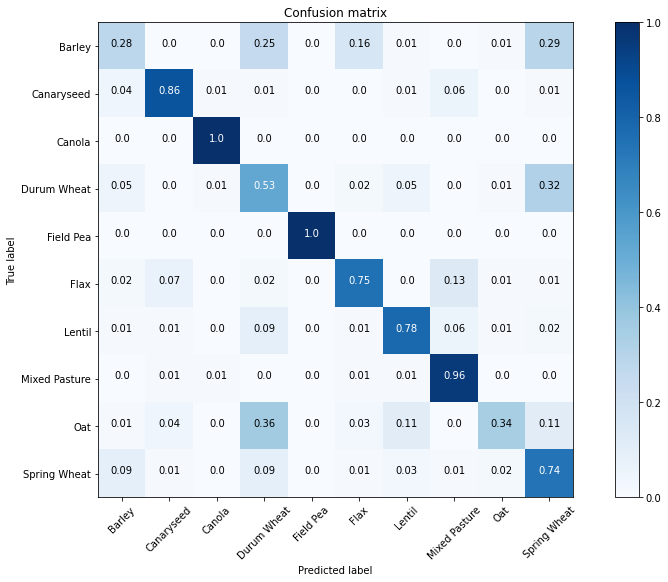

In [ ]:
classes = ['Barley', 'Canaryseed', 'Canola', 'Durum Wheat', 'Field Pea', 'Flax', 'Lentil', 'Mixed Pasture', 'Oat', 'Spring Wheat']
eval_model(y_test0,y_pred,classes,model_name)

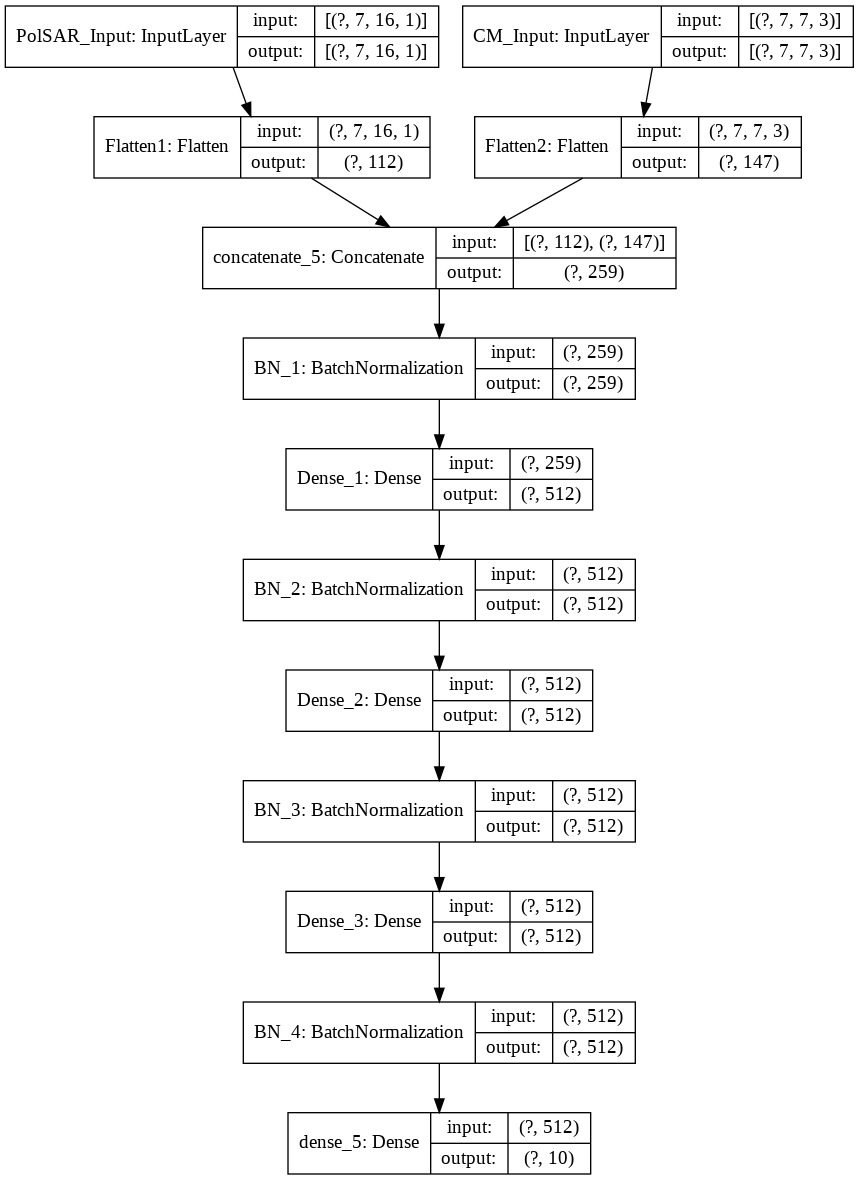

In [ ]:
tf.keras.utils.plot_model(model_CS, to_file=dot_img_file, show_shapes=True)

# More complex concatenation of inputs

In [ ]:
def model_conc_complex(in_tensor1, in_tensor2, Num_classes, name_in_lay1, name_in_lay2):
  # functional API model
  # define two sets of inputs
  input_1 = tf.keras.Input(shape= (in_tensor1.shape[1],in_tensor1.shape[2],in_tensor1.shape[3]),  name=name_in_lay1)
  input_2 = tf.keras.Input(shape=(in_tensor2.shape[1],in_tensor2.shape[2],in_tensor2.shape[3]),name=name_in_lay2)

  x1 = tf.keras.layers.Flatten(name='Flatten1')(input_1)
  x1 = tf.keras.layers.BatchNormalization(name='BN_11')(x1)
  x1 = tf.keras.layers.Dense(512,activation='relu',name='Dense_11')(x1)
  x1 = tf.keras.layers.BatchNormalization(name='BN_12')(x1)
  x1 = tf.keras.layers.Dense(512,activation='relu',name='Dense_12')(x1)
  x1 = tf.keras.layers.BatchNormalization(name='BN_13')(x1)
  x1 = tf.keras.layers.Dense(512,activation='relu',name='Dense_13')(x1)
  x1 = tf.keras.layers.BatchNormalization(name='BN_14')(x1)
  #out1= tf.keras.layers.Dense(Num_classes, activation='softmax')(x1)

  x2 = tf.keras.layers.Flatten(name='Flatten2')(input_2)
  x2 = tf.keras.layers.BatchNormalization(name='BN_21')(x2)
  x2 = tf.keras.layers.Dense(512,activation='relu',name='Dense_21')(x2)
  x2 = tf.keras.layers.BatchNormalization(name='BN_22')(x2)
  x2 = tf.keras.layers.Dense(512,activation='relu',name='Dense_22')(x2)
  x2 = tf.keras.layers.BatchNormalization(name='BN_23')(x2)
  x2 = tf.keras.layers.Dense(512,activation='relu',name='Dense_23')(x2)
  x2 = tf.keras.layers.BatchNormalization(name='BN_24')(x2)
  #out2= tf.keras.layers.Dense(Num_classes, activation='softmax')(x2)

  x = tf.keras.layers.concatenate([x1,x2])

  x = tf.keras.layers.BatchNormalization(name='BN_A')(x)
  x = tf.keras.layers.Dense(512,activation='relu',name='Dense_A')(x)
  x = tf.keras.layers.BatchNormalization(name='BN_B')(x)
  #x = tf.keras.layers.Dense(512,activation='relu',name='Dense_2')(x)
  #x = tf.keras.layers.BatchNormalization(name='BN_3')(x)
  #x = tf.keras.layers.Dense(512,activation='relu',name='Dense_3')(x)
  #x = tf.keras.layers.BatchNormalization(name='BN_4')(x)

  outputs = tf.keras.layers.Dense(Num_classes, activation='softmax')(x)
  model = tf.keras.Model(inputs=[input_1,input_2], outputs=outputs)
  #model = tf.keras.Model(inputs=[input_1,input_2], outputs=outputs)
  return(model)

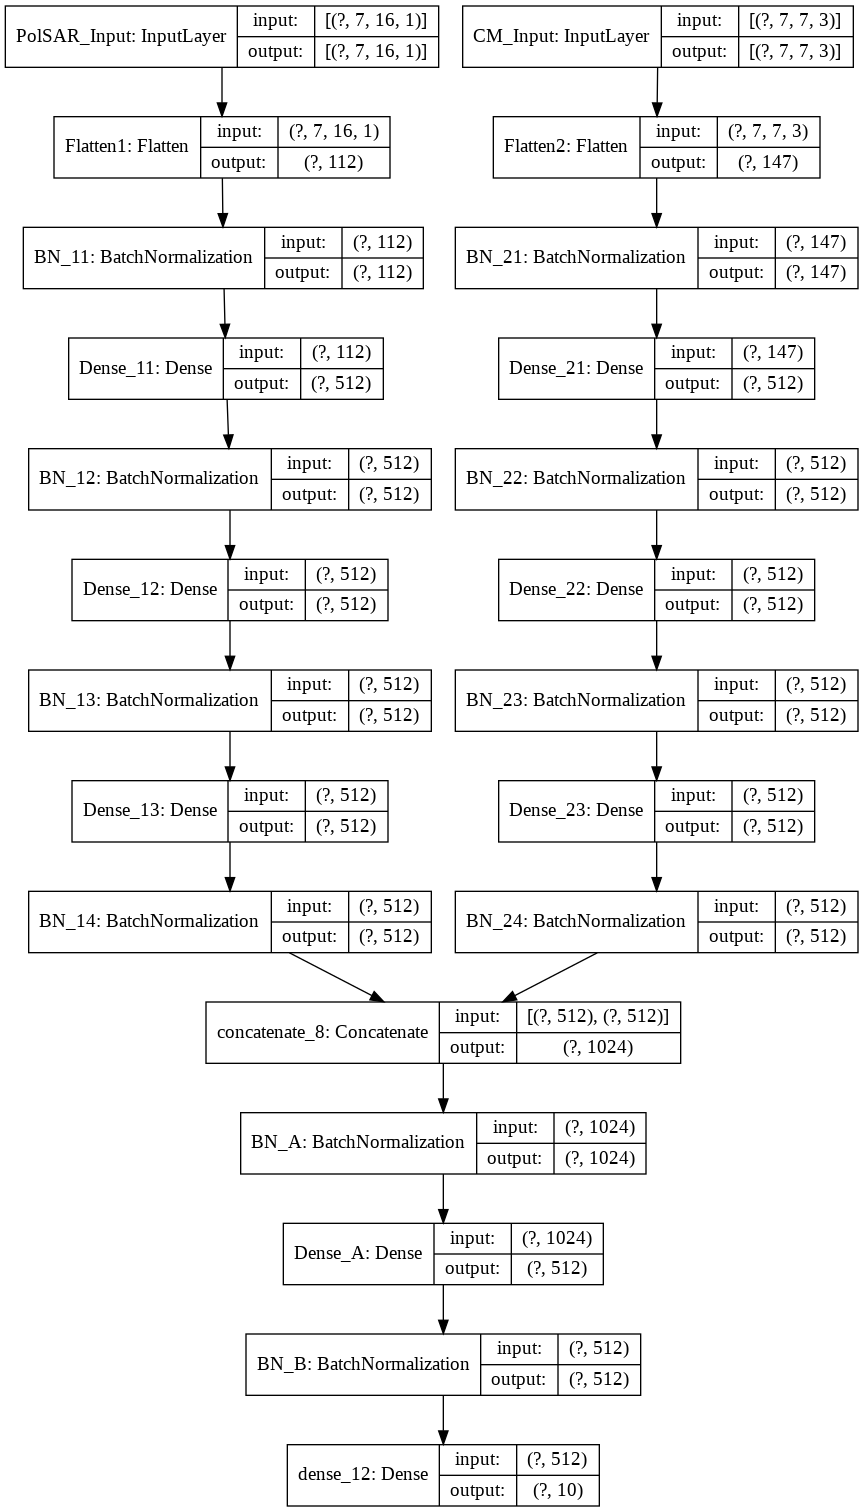

In [ ]:
Lr_call = tf.keras.callbacks.LearningRateScheduler(scheduler)
metrics_mine=My_Metrics([X_test_2d[:samples],X_test_CM_2d[:samples]],y_for_testing_sparse[:samples])  # Pass sparse ground truth, not categorical
model=model_conc_complex(in_tensor1 = X_train_2d[:samples],in_tensor2=X_train_CM_2d[:samples], Num_classes = 10, name_in_lay1 = 'PolSAR_Input',name_in_lay2 = 'CM_Input')
dot_img_file = '/content/model_1.png'
tf.keras.utils.plot_model(model, to_file=dot_img_file, show_shapes=True)

In [ ]:
optimizer = tf.keras.optimizers.SGD(lr=1e-3) # try also 3e-6
model.compile(optimizer = optimizer,
              loss = ncce,
              #tf.keras.losses.SparseCategoricalCrossentropy(),#'categorical_crossentropy' is for one hot encoded labels, # , #adam: adaptive moment estimation
              metrics=['accuracy'])

metrics_mine.on_train_begin()
history = model.fit(x=([X_train_2d[:samples],X_train_CM_2d[:samples]]), y=Y_train[:samples], 
                    epochs = 30, batch_size = 32,
                    validation_data=([X_test_2d[:samples],X_test_CM_2d[:samples]],Y_test[:samples]),
                    verbose=True, callbacks=[metrics_mine,Lr_call],
                    #class_weight=class_weight_dict,
                    sample_weight = sample_weight #sample_weight#sample_weight_small#sample_weight_val 
)

Epoch 1/30
29468/29469 [============================>.] - ETA: 0s - loss: 0.2119 - accuracy: 0.8780 
Bal_accuracy: 0.712
F1_macro: 0.698
Imbal_accuracy: 0.805
Highest balanced accuracy so far. Saving model ...
29469/29469 [==============================] - 898s 30ms/step - loss: 0.2119 - accuracy: 0.8780 - val_loss: 1.3939 - val_accuracy: 0.8046
Epoch 2/30
29468/29469 [============================>.] - ETA: 0s - loss: 0.1108 - accuracy: 0.9276 
Bal_accuracy: 0.713
F1_macro: 0.693
Imbal_accuracy: 0.806
Highest balanced accuracy so far. Saving model ...
29469/29469 [==============================] - 916s 31ms/step - loss: 0.1108 - accuracy: 0.9276 - val_loss: 1.4200 - val_accuracy: 0.8057
Epoch 3/30
29468/29469 [============================>.] - ETA: 0s - loss: 0.0882 - accuracy: 0.9378 
Bal_accuracy: 0.711
F1_macro: 0.693
Imbal_accuracy: 0.809
Balanced accuracy did not improve. (1)
29469/29469 [==============================] - 948s 32ms/step - loss: 0.0882 - accuracy: 0.9378 - val_loss

KeyboardInterrupt: ignored

In [ ]:
model_name='/content/All_base_small_mine.h5'
model_CS = load_model(model_name, custom_objects={'w_categorical_crossentropy': ncce})
#meta_model_DNN = DNN_fit_stacked_model_ensambling(members, X_val, members2, X_val_CM, y_val,sample_weight,stack_X_test,y_test)
y_pred = np.argmax(model_CS.predict([X_test_2d[:samples],X_test_CM_2d[:samples]]), axis=-1)

                     NN_All_small
f1_macro                 0.692759
G_mean_macro             0.834806
Balanced accuracy        0.712683
Imbalanced accuracy      0.805747
 
               precision    recall  f1-score        support
Barley          0.334465  0.285113  0.307823   22812.000000
Canaryseed      0.684298  0.827656  0.749181    8425.000000
Canola          0.995339  0.996726  0.996032   92554.000000
Durum Wheat     0.303099  0.505170  0.378875   19342.000000
Field Pea       0.981513  0.996242  0.988823   38851.000000
Flax            0.688045  0.718429  0.702909   19203.000000
Lentil          0.732653  0.768012  0.749916   18876.000000
Mixed Pasture   0.858017  0.959299  0.905836   38427.000000
Oat             0.378291  0.332274  0.353793    5664.000000
Spring Wheat    0.860255  0.737907  0.794398  123834.000000
accuracy        0.805747  0.805747  0.805747       0.805747
macro avg       0.681598  0.712683  0.692759  387988.000000
weighted avg    0.820122  0.805747  0.809574  38

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

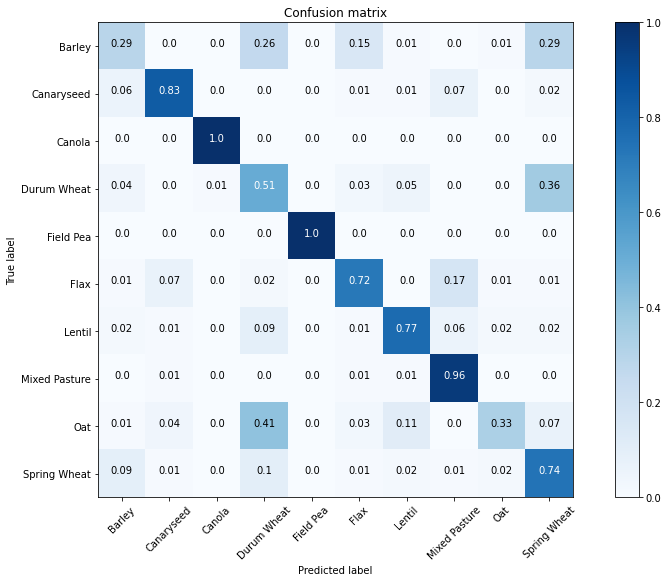

In [ ]:
classes = ['Barley', 'Canaryseed', 'Canola', 'Durum Wheat', 'Field Pea', 'Flax', 'Lentil', 'Mixed Pasture', 'Oat', 'Spring Wheat']
eval_model(y_test0,y_pred,classes,model_name)

# Stacking NNs

In [ ]:
# Determine weight of each class according to number of samples
# For train
class_weights_lev2 = class_weight.compute_class_weight('balanced',
                                                 np.unique(y_train0_lev2),
                                                 y_train0_lev2)
class_weight_dict_lev2 = dict(enumerate(class_weights_lev2/class_weights_lev2.max())) # normalize the weights to one

sample_weight_lev2=np.zeros(y_train0_lev2.shape)
for r in np.unique(y_train0_lev2):
  sample_weight_lev2=np.where(y_train0_lev2==r,class_weight_dict_lev2[r],sample_weight_lev2)

print(np.unique(sample_weight_lev2))
print(class_weight_dict_lev2)

[0.1080622  0.17139643 0.38495811 0.4309055  0.43634582 0.48961813
 0.49761465 0.83601704 0.97057591 1.        ]
{0: 1.0, 1: 0.8360170409415841, 2: 0.1713964264037542, 3: 0.4976146473546224, 4: 0.43090550448472215, 5: 0.38495810613113446, 6: 0.48961813337844123, 7: 0.43634582045677245, 8: 0.9705759074524267, 9: 0.10806219783091597}


In [ ]:
def meta_learner(in_tensor, Num_classes, name_in_lay):
  # functional API model
  # define two sets of inputs
  input_1 = tf.keras.Input(shape=(in_tensor.shape[1],),name=name_in_lay)
  #input_2 = tf.keras.Input(shape=(X_train_CM_2d.shape[1],X_train_CM_2d.shape[2],X_train_CM_2d.shape[3]))
  x1 = tf.keras.layers.Flatten(name='Flatten')(input_1)
  #x = tf.keras.layers.concatenate([x1,x2])
  x = tf.keras.layers.BatchNormalization(name='BN_1')(x1)
  x = tf.keras.layers.Dense(128,activation='relu',name='Dense_1')(x)
  x = tf.keras.layers.BatchNormalization(name='BN_2')(x)
  #x = tf.keras.layers.Dropout(0.2)(x)
  x = tf.keras.layers.Dense(128,activation='relu',name='Dense_2')(x)
  x = tf.keras.layers.BatchNormalization(name='BN_3')(x)
  #x = tf.keras.layers.Dropout(0.2)(x)
  #x = tf.keras.layers.Dense(512,activation='relu',name='Dense_3')(x)
  #x = tf.keras.layers.BatchNormalization(name='BN_4')(x)
  #x = tf.keras.layers.Dropout(0.2)(x)
  outputs = tf.keras.layers.Dense(Num_classes, activation='softmax')(x)
  model = tf.keras.Model(inputs=input_1, outputs=outputs)
  #model = tf.keras.Model(inputs=[input_1,input_2], outputs=outputs)
  return(model)

In [ ]:
def stacked_dataset(members, inputX):
  #inputX = X_val1
  stackX = np.zeros((inputX.shape[0]))  # start a column of empty zeros to which we will append more columns to the right
  for model in members:
    # make prediction
    yhat = model.predict(inputX, verbose=0)
    #print(yhat.shape)
    # stack predictions into [rows, members, probabilities]
    if stackX is None:
      stackX = yhat
    else:
      stackX = np.column_stack((stackX, yhat))
  stackX = np.delete(stackX, 0, 1)
  return stackX

# # fit a model based on the outputs from the ensemble members
# def fit_stacked_model(members, inputX, inputy):
#   # create dataset using ensemble
#   stackedX = stacked_dataset(members, inputX)
#   #print(stackedX.shape)
#   #print(inputy.shape)
#   # fit standalone model
#   #model = LogisticRegression()
#   model = RandomForestClassifier(n_estimators = 100, 
#                                     criterion = 'entropy',
#                                     random_state = seed,
#                                     max_depth=8,
#                                     n_jobs=-1,
#                                     verbose=False)
#   # model = BalancedRandomForestClassifier(n_estimators = 200, 
#   #                                   criterion = 'entropy',
#   #                                   random_state = seed,
#   #                                   max_depth=8,
#   #                                   n_jobs=-1,
#   #                                   verbose=False)
#   print("Fitting meta-learner")
#   model.fit(stackedX, inputy)
#   return model

# make a prediction with the stacked model
# def stacked_prediction(members, model, inputX):
# 	# create dataset using ensemble
# 	stackedX = stacked_dataset(members, inputX)
# 	# make a prediction
# 	yhat = model.predict(stackedX)
# 	return yhat

In [ ]:
# def fit_stacked_model_ensambling(members, inputX, members2, inputX2, inputy):
#   # create dataset using ensemble
#   stackedX  = stacked_dataset(members, inputX)
#   stackedX2 = stacked_dataset(members2, inputX2)
#   print(stackedX.shape)
#   print(stackedX2.shape)
#   print(inputy.shape)
#   stack_X = np.column_stack((stackedX, stackedX2))
#   print(stack_X.shape)
#   # fit standalone model
#   #model = LogisticRegression()
#   model = RandomForestClassifier(n_estimators = 100, 
#                                     criterion = 'entropy',
#                                     random_state = seed,
#                                     max_depth=8,
#                                     n_jobs=-1,
#                                     verbose=False)
#   # model = BalancedRandomForestClassifier(n_estimators = 200, 
#   #                                   criterion = 'entropy',
#   #                                   random_state = seed,
#   #                                   max_depth=8,
#   #                                   n_jobs=-1,
#   #                                   verbose=False)
#   print("Fitting meta-learner")
#   model.fit(stack_X, inputy)
#   return model

def DNN_fit_stacked_model_ensambling(stack_X, inputy,sample_weight_,X_for_testing_,y_for_testing_,y_for_testing_sparse_,Num_classes):

  # Create standalone model
  model = meta_learner(in_tensor=stack_X, Num_classes=Num_classes, name_in_lay='Stacked_Input')
  #model_name='Meta_learner.h5'
  #model = load_model(model_name)
  # Callbacks
  Lr_call = tf.keras.callbacks.LearningRateScheduler(scheduler)
  metrics_mine=My_Metrics(X_for_testing_,y_for_testing_sparse_)  # Pass sparse ground truth, not categorical
  dot_img_file = '/content/model_1.png'
  optimizer = tf.keras.optimizers.SGD(lr=1e-3) # try also 3e-6
  
  model.compile(optimizer = optimizer,
              loss = ncce,
              #tf.keras.losses.SparseCategoricalCrossentropy(),#'categorical_crossentropy' is for one hot encoded labels, # , #adam: adaptive moment estimation
              metrics=['accuracy'])

  print("Fitting meta-learner")
  metrics_mine.on_train_begin()
  history = model.fit(x=stack_X, y=inputy,
                      epochs = 10, batch_size = 32,
                      validation_data=(X_for_testing_,y_for_testing_),
                      verbose=True,
                      callbacks=[metrics_mine,Lr_call],
                      sample_weight = sample_weight_)
    
  print("Meta-learner training finished")
  return (model) 

# make a prediction with the stacked model
def stacked_prediction_ensamble(members, members2, model, inputX, inputX2):
  # create dataset using ensemble
  stackedX = stacked_dataset(members, inputX) #[No_samples,30]
  stackedX2 = stacked_dataset(members2, inputX2) #[No_samples,30]
  stack_X = np.column_stack((stackedX, stackedX2)) #[No_samples,60]
  # make a prediction
  yhat = model.predict(stack_X)
  return yhat

# make a prediction with the stacked model
def DNN_stacked_prediction_ensamble(members, members2, model, inputX, inputX2):
  # create dataset using ensemble
  stackedX = stacked_dataset(members, inputX) #[No_samples,30]
  stackedX2 = stacked_dataset(members2, inputX2) #[No_samples,30]
  stack_X = np.column_stack((stackedX, stackedX2)) #[No_samples,60]
  # make a prediction
  yhat = np.argmax(model.predict(stack_X), axis=-1)
  return yhat

In [ ]:
# PolSAR_all
# model_paths = [ #"/content/drive/MyDrive/Datasets/AgriSAR_Paper2/NN_PolSAR_Results/All/NN_all_V2.h5",
#                 "/content/drive/MyDrive/Datasets/AgriSAR_Paper2/NN_PolSAR_Results/All/Under_NN_all_V2.h5"
#                # "/content/drive/MyDrive/Datasets/AgriSAR_Paper2/NN_PolSAR_Results/All/Imb_Under_NN_all_V2.h5"
#                ]
# members = load_all_models(model_paths)
# print('Loaded %d models' % len(members))

In [ ]:
# # CM_all
# model_paths = [ #"/content/drive/MyDrive/Datasets/AgriSAR_Paper2/NN_CM_Results/All/NN_all_CM_V1.h5",
#                 "/content/drive/MyDrive/Datasets/AgriSAR_Paper2/NN_CM_Results/All/Under_NN_all_CM_V1.h5"
#                 #"/content/drive/MyDrive/Datasets/AgriSAR_Paper2/NN_CM_Results/All/Imb_Under_NN_all_CM_V1.h5"
#                ]
# members2 = load_all_models(model_paths)
# print('Loaded %d models' % len(members))

#### Load level 1 models and use them to predict on the level 2 training set, to create the meta-learner training set

In [ ]:
root_models="/content/drive/My Drive/Datasets/AgriSAR_Paper2/Models/V2/"

model_CS = load_model(root_models + 'PolSAR_Nadam_1e_4.h5', custom_objects={'w_categorical_crossentropy': ncce})
members=[model_CS]

model_CS1 = load_model(root_models + 'CM_Adam_1e_4.h5', custom_objects={'w_categorical_crossentropy': ncce})
members2=[model_CS1]

In [ ]:
# create meta-learner dataset using ensemble
stackedX  = stacked_dataset(members, X_train_lev2_2d)
stackedX2 = stacked_dataset(members2, X_train_CM_lev2_2d)
print(stackedX.shape)
print(stackedX2.shape)

(342442, 10)
(342442, 10)


In [ ]:
print(Y_val.shape)
stack_X = np.column_stack((stackedX, stackedX2))
print(stack_X.shape)

(342442, 10)
(342442, 20)


In [ ]:
aaab=np.argmax(stackedX,axis=1)
f1_macro = f1_score(y_train0_lev2, aaab, average='macro')
Bal_acc = balanced_accuracy_score(y_train0_lev2, aaab, sample_weight=None, adjusted=False)
print('f1_macro: '+str(f1_macro))
print('Bal_acc: '+str(Bal_acc))

f1_macro: 0.70182657780245
Bal_acc: 0.7347887518251539


In [ ]:
aaab=np.argmax(stackedX2,axis=1)
f1_macro = f1_score(y_train0_lev2, aaab, average='macro')
Bal_acc = balanced_accuracy_score(y_train0_lev2, aaab, sample_weight=None, adjusted=False)
print('f1_macro: '+str(f1_macro))
print('Bal_acc: '+str(Bal_acc))

f1_macro: 0.6497814321602717
Bal_acc: 0.6768555327936737


In [ ]:
np.all(y_train0_lev2 == y_train_CM0_lev2)

True

In [ ]:
stackedX = stacked_dataset(members, X_test_2d) #[No_samples,30]
stackedX2 = stacked_dataset(members2, X_test_CM_2d) #[No_samples,30]
stack_X_test = np.column_stack((stackedX, stackedX2)) #[No_samples,60]

In [ ]:
# # Create standalone model
# model = meta_learner(in_tensor=stack_X, Num_classes=10, name_in_lay='Stacked_Input')

# # Callbacks
# Lr_call = tf.keras.callbacks.LearningRateScheduler(scheduler)
# metrics_mine=My_Metrics(stack_X_test,y_test0,'Stack_of_NN')  # Pass sparse ground truth, not categorical

# optimizer = tf.keras.optimizers.SGD(lr=1e-4) # try also 3e-6

# model.compile(optimizer = optimizer,
#             loss = ncce,
#             #tf.keras.losses.SparseCategoricalCrossentropy(),#'categorical_crossentropy' is for one hot encoded labels, # , #adam: adaptive moment estimation
#             metrics=['accuracy'])

# print("Fitting meta-learner")
# metrics_mine.on_train_begin()
# history = model.fit(x=stack_X, y=Y_val,
#                     epochs = 30, batch_size = 32,
#                     validation_data=(stack_X_test,Y_test), # categorical classes for y_test
#                     verbose=True,
#                     callbacks=[metrics_mine],#,Lr_call],
#                     sample_weight = sample_weight_lev2)

In [ ]:
classes = ['Barley', 'Canaryseed', 'Canola', 'Durum Wheat', 'Field Pea', 'Flax', 'Lentil', 'Mixed Pasture', 'Oat', 'Spring Wheat']
model_name_list = ['Stack_NN_Adam','Stack_NN_SGD','Stack_NN_Nadam']
model_name_list

['Stack_NN_Adam', 'Stack_NN_SGD', 'Stack_NN_Nadam']

Epoch 1/20
10700/10702 [============================>.] - ETA: 0s - loss: 0.5883 - accuracy: 0.7940 
Bal_accuracy: 0.7
F1_macro: 0.683
Imbal_accuracy: 0.78
Highest balanced accuracy so far. Saving model ...
10702/10702 [==============================] - 124s 12ms/step - loss: 0.5882 - accuracy: 0.7940 - val_loss: 1.6705 - val_accuracy: 0.7799
Epoch 2/20
10697/10702 [============================>.] - ETA: 0s - loss: 0.5004 - accuracy: 0.8047 
Bal_accuracy: 0.698
F1_macro: 0.682
Imbal_accuracy: 0.779
Balanced accuracy did not improve. (1)
10702/10702 [==============================] - 121s 11ms/step - loss: 0.5004 - accuracy: 0.8047 - val_loss: 1.6507 - val_accuracy: 0.7790
Epoch 3/20
10699/10702 [============================>.] - ETA: 0s - loss: 0.4845 - accuracy: 0.8069 
Bal_accuracy: 0.698
F1_macro: 0.684
Imbal_accuracy: 0.781
Balanced accuracy did not improve. (2)
10702/10702 [==============================] - 121s 11ms/step - loss: 0.4846 - accuracy: 0.8069 - val_loss: 1.6275 - val_

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Epoch 1/20
10694/10702 [============================>.] - ETA: 0s - loss: 1.2034 - accuracy: 0.6445 
Bal_accuracy: 0.699
F1_macro: 0.673
Imbal_accuracy: 0.766
Highest balanced accuracy so far. Saving model ...
10702/10702 [==============================] - 119s 11ms/step - loss: 1.2031 - accuracy: 0.6446 - val_loss: 1.9922 - val_accuracy: 0.7663
Epoch 2/20
10699/10702 [============================>.] - ETA: 0s - loss: 0.7549 - accuracy: 0.7604 
Bal_accuracy: 0.713
F1_macro: 0.686
Imbal_accuracy: 0.777
Highest balanced accuracy so far. Saving model ...
10702/10702 [==============================] - 117s 11ms/step - loss: 0.7549 - accuracy: 0.7604 - val_loss: 1.8853 - val_accuracy: 0.7766
Epoch 3/20
10700/10702 [============================>.] - ETA: 0s - loss: 0.7086 - accuracy: 0.7673 
Bal_accuracy: 0.713
F1_macro: 0.686
Imbal_accuracy: 0.777
Balanced accuracy did not improve. (1)
10702/10702 [==============================] - 117s 11ms/step - loss: 0.7086 - accuracy: 0.7673 - val_loss

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Epoch 1/20
10698/10702 [============================>.] - ETA: 0s - loss: 0.5789 - accuracy: 0.7915 
Bal_accuracy: 0.703
F1_macro: 0.69
Imbal_accuracy: 0.785
Highest balanced accuracy so far. Saving model ...
10702/10702 [==============================] - 134s 12ms/step - loss: 0.5789 - accuracy: 0.7915 - val_loss: 1.5562 - val_accuracy: 0.7853
Epoch 2/20
10697/10702 [============================>.] - ETA: 0s - loss: 0.4864 - accuracy: 0.8084 
Bal_accuracy: 0.699
F1_macro: 0.684
Imbal_accuracy: 0.78
Balanced accuracy did not improve. (1)
10702/10702 [==============================] - 135s 13ms/step - loss: 0.4865 - accuracy: 0.8084 - val_loss: 1.6234 - val_accuracy: 0.7800
Epoch 3/20
10698/10702 [============================>.] - ETA: 0s - loss: 0.4822 - accuracy: 0.8079 
Bal_accuracy: 0.698
F1_macro: 0.686
Imbal_accuracy: 0.783
Balanced accuracy did not improve. (2)
10702/10702 [==============================] - 132s 12ms/step - loss: 0.4822 - accuracy: 0.8079 - val_loss: 1.5838 - val

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

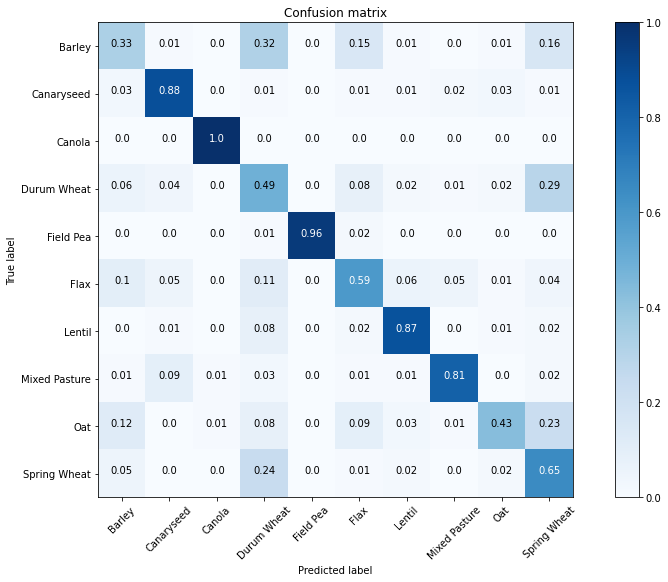

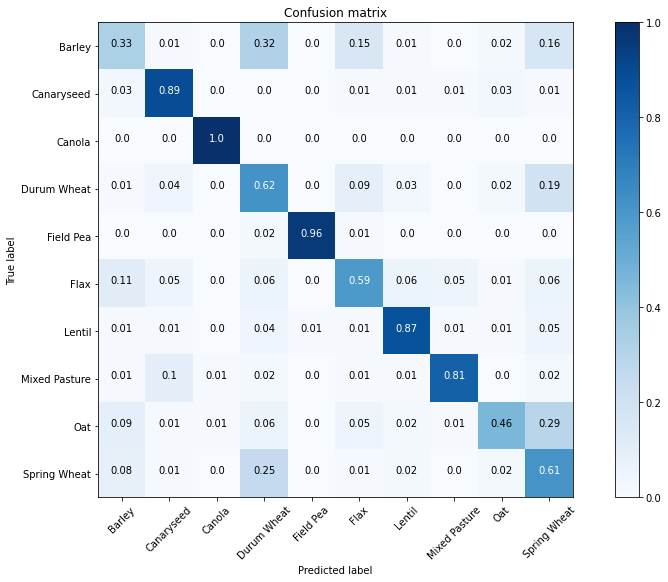

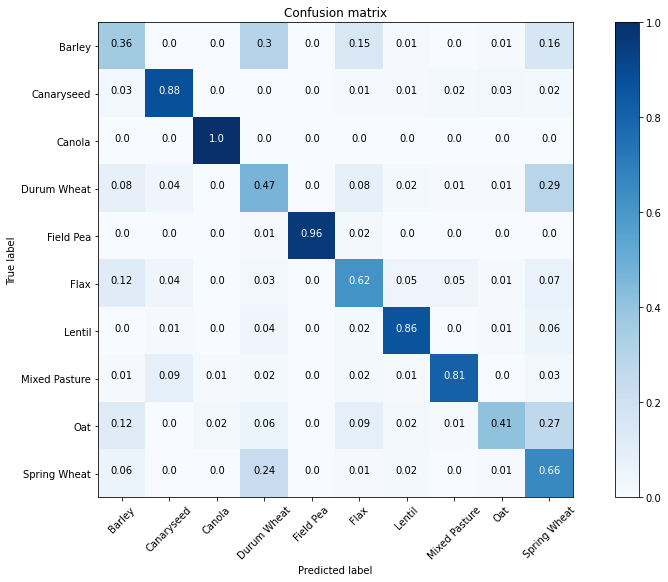

In [ ]:
for i in range(len(optimizers_list)):
  save_model_name= model_name_list[i]
  metrics_mine=My_Metrics(stack_X_test,y_test0,save_model_name=save_model_name)  # Pass sparse ground truth, not categorical
  model_Stack=meta_learner(in_tensor = stack_X, Num_classes = 10, name_in_lay = 'Stack_NN')
  dot_img_file = '/content/model_1.png'

  optimizer = optimizers_list[i]
  model_Stack.compile(optimizer = optimizer,
                loss = ncce,
                #tf.keras.losses.SparseCategoricalCrossentropy(),#'categorical_crossentropy' is for one hot encoded labels, # , #adam: adaptive moment estimation
                metrics=['accuracy'])

  metrics_mine.on_train_begin()
  history = model_Stack.fit(x=stack_X, y=Y_val, 
                      epochs = 20, batch_size = 32,
                      validation_data=(stack_X_test,y_for_testing),
                      verbose=True, 
                      #callbacks=[metrics_mine],
                      callbacks=[metrics_mine,Lr_call],
                      #class_weight=class_weight_dict,
                      sample_weight = sample_weight_lev2 #sample_weight#sample_weight_small#sample_weight_val 
  )
  model_Stack_CS = load_model(save_model_name+'.h5', custom_objects={'w_categorical_crossentropy': ncce})
  y_pred = np.argmax(model_Stack_CS.predict(stack_X_test), axis=-1)
  eval_model(y_for_testing_sparse,y_pred,classes,save_model_name)  

# Test CNN

In [ ]:
def CNN_model(in_tensor, Num_classes, name_in_lay):
  # functional API model
  # define two sets of inputs
  input_1 = tf.keras.Input(shape=(in_tensor.shape[1],in_tensor.shape[2],in_tensor.shape[3]),name=name_in_lay)
  x = tf.keras.layers.Conv2D(16, activation='relu', kernel_size=3)(input_1)
  x = tf.keras.layers.Conv2D(50, activation='relu', kernel_size=3)(x)
  #x = tf.keras.layers.Conv2D(16, activation='relu', kernel_size=3)(x)

  x1 = tf.keras.layers.Flatten(name='Flatten')(input_1)
  #x = tf.keras.layers.concatenate([x1,x2])
  x = tf.keras.layers.BatchNormalization(name='BN_1')(x1)
  x = tf.keras.layers.Dense(512,activation='relu',name='Dense_1')(x)
  x = tf.keras.layers.BatchNormalization(name='BN_2')(x)
  #x = tf.keras.layers.Dropout(0.2)(x)
  x = tf.keras.layers.Dense(512,activation='relu',name='Dense_2')(x)
  x = tf.keras.layers.BatchNormalization(name='BN_3')(x)
  #x = tf.keras.layers.Dropout(0.2)(x)
  x = tf.keras.layers.Dense(512,activation='relu',name='Dense_3')(x)
  x = tf.keras.layers.BatchNormalization(name='BN_4')(x)
  #x = tf.keras.layers.Dropout(0.2)(x)
  outputs = tf.keras.layers.Dense(Num_classes, activation='softmax')(x)
  model = tf.keras.Model(inputs=input_1, outputs=outputs)
  #model = tf.keras.Model(inputs=[input_1,input_2], outputs=outputs)
  return(model)

In [ ]:
def CNN_model_slid_win(in_tensor, Num_classes, name_in_lay):
  input_1 = tf.keras.Input(shape=(in_tensor.shape[1],in_tensor.shape[2],in_tensor.shape[3]),name=name_in_lay)
  x = tf.keras.layers.BatchNormalization(name='BN_1')(input_1)
  x = tf.keras.layers.Conv2D(64, activation='relu', kernel_size=(3,3))(x)
  x = tf.keras.layers.BatchNormalization(name='BN_2')(x)
  x = tf.keras.layers.Conv2D(128, activation='relu', kernel_size=(3,3))(x)
  x = tf.keras.layers.BatchNormalization(name='BN_3')(x)
  x = tf.keras.layers.Conv2D(512, activation='relu', kernel_size=(1,1))(x)
  x = tf.keras.layers.BatchNormalization(name='BN_4')(x)
  x = tf.keras.layers.MaxPool2D(pool_size=(3,3))(x)
  x = tf.keras.layers.Conv2D(128, kernel_size=(1,1), activation='relu')(x)
  x = tf.keras.layers.BatchNormalization(name='BN_5')(x)
  x = tf.keras.layers.Conv2D(Num_classes, kernel_size=(1,1), activation='relu')(x)
  x = tf.keras.layers.BatchNormalization(name='BN_6')(x)
  
  x = tf.keras.layers.GlobalAveragePooling2D()(x)
  #outputs = tf.keras.layers.Flatten(name='Flatten')(outputs)
  outputs = (tf.keras.layers.Activation('softmax'))(x)
  #outputs = tf.keras.layers.Flatten(name='Flatten')(outputs)
  model = tf.keras.Model(inputs=input_1, outputs=outputs)
  return(model)

In [ ]:
Lr_call = tf.keras.callbacks.LearningRateScheduler(scheduler)
metrics_mine=My_Metrics(X_for_validating, y_for_validating_sparse,save_model_name='Test_CNN')  # Pass sparse ground truth, not categorical
model=CNN_model_slid_win(in_tensor = X_for_training, Num_classes = 10, name_in_lay = 'CM_Input') #CNN_model_slid_win CNN_model
dot_img_file = '/content/model_1.png'

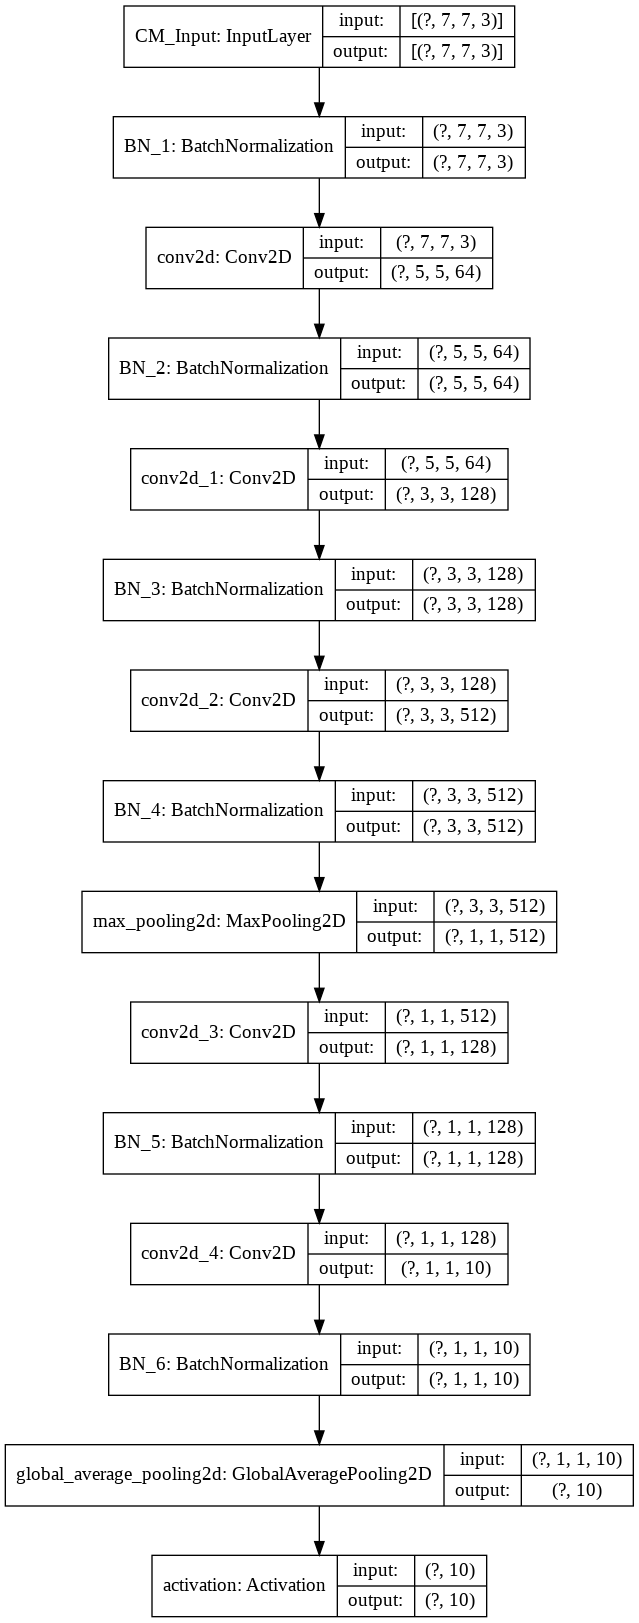

In [ ]:
optimizer = tf.keras.optimizers.Nadam(lr=1e-4) # try also 3e-6
model.compile(optimizer = optimizer,
              loss = 'categorical_crossentropy',#ncce,
              #tf.keras.losses.SparseCategoricalCrossentropy(),#'categorical_crossentropy' is for one hot encoded labels, # , #adam: adaptive moment estimation
              metrics=['accuracy'])
tf.keras.utils.plot_model(model, to_file=dot_img_file, show_shapes=True)

In [ ]:
# summarize model
model.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
CM_Input (InputLayer)        [(None, 7, 7, 3)]         0         
_________________________________________________________________
BN_1 (BatchNormalization)    (None, 7, 7, 3)           12        
_________________________________________________________________
conv2d (Conv2D)              (None, 5, 5, 64)          1792      
_________________________________________________________________
BN_2 (BatchNormalization)    (None, 5, 5, 64)          256       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 3, 3, 128)         73856     
_________________________________________________________________
BN_3 (BatchNormalization)    (None, 3, 3, 128)         512       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 3, 3, 512)        

In [ ]:
#metrics_mine.on_train_begin()
history = model.fit(x=X_for_training, y=y_for_training, 
                    epochs = 10, batch_size = 32,
                    validation_data=(X_for_validating,y_for_validating),
                    verbose=True, callbacks=[metrics_mine,Lr_call],
                    #class_weight=class_weight_dict,
                    #sample_weight = sample_weight #sample_weight#sample_weight_small#sample_weight_val 
)

Epoch 1/10
30585/30586 [============================>.] - ETA: 0s - loss: 0.3549 - accuracy: 0.9171 
Bal_accuracy: 0.59
F1_macro: 0.58
Imbal_accuracy: 0.743
Highest balanced accuracy so far. Saving model ...
30586/30586 [==============================] - 604s 20ms/step - loss: 0.3549 - accuracy: 0.9171 - val_loss: 0.9661 - val_accuracy: 0.7432
Epoch 2/10
 5300/30586 [====>.........................] - ETA: 7:24 - loss: 0.1548 - accuracy: 0.9565

KeyboardInterrupt: ignored

In [ ]:
model_CNN = load_model('Test_CNN.h5')
y_pred = np.argmax(model_CNN.predict(X_for_testing), axis=-1)
#eval_model(y_for_testing_sparse,y_pred,classes,save_model_name) 

In [ ]:
y_pred.shape

(483045,)

In [ ]:
a = X_for_training[2000:2003,:,:,:]
b = X_for_training[20000:20003,:,:,:]
c = X_for_training[30000:30003,:,:,:]

In [ ]:
a.shape

(3, 7, 7, 3)

(21, 28, 3)


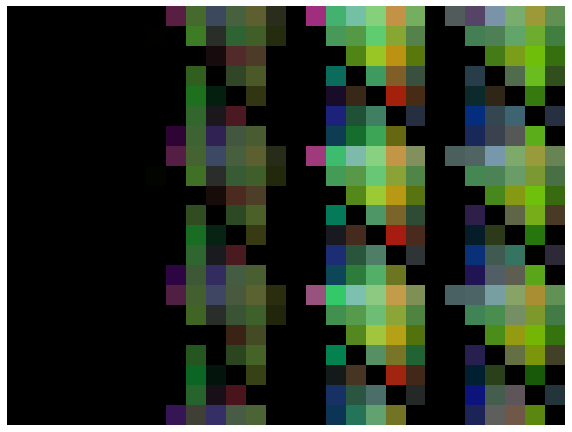

In [ ]:
x0=np.zeros((7,7,3)) 
list_rows=[]
for i in range(a.shape[0]):
  x1=x0.copy()
  #for j in range(a.shape[1]):
  x2=a[i,:,:,:] # one change matrix for pixel i,j
  x3=b[i,:,:,:] # one change matrix for pixel i,j
  x4=c[i,:,:,:] # one change matrix for pixel i,j
  x1=np.hstack((x1, x2, x3, x4))
  list_rows.append(x1)
    
aaa=np.vstack(list_rows)
#x3=np.vstack((x1, x1a))

fig,ax=plt.subplots(figsize=(10,9))
ax.imshow(aaa)
plt.axis('off')

print(aaa.shape)

In [ ]:
bbb = np.expand_dims(aaa, axis=0)
bbb.shape

(1, 21, 28, 3)

In [ ]:
y_pred = np.argmax(model_CNN.predict(bbb), axis=-1)

In [ ]:
y_pred

array([4])

In [ ]:
y_pred = model_CNN.predict(bbb)
y_pred.shape

(1, 10)

In [ ]:
a.shape

(3, 7, 7, 3)

In [ ]:
y_pred_A = model_CNN.predict(a)
y_pred_A.shape

(3, 10)

In [ ]:
y_pred_A = np.argmax(model_CNN.predict(a), axis=-1)
y_pred_A

array([7, 7, 7])